## Disk usage analysis
We have preprocessed data for 1697 basins. Here we provide an overview of the disk space needed to store this information, and create a plot that divides the data set into (i) headwater, (ii) meso-scale, and (iii) macro-scale basins.

In [1]:
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [116]:
# Get the required info from the config file
data_path            = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

# Disk usage file
du_file = basins_path / 'disk_usage.txt'

# Image output folder
image_folder = cs.read_from_config(config_file, 'image_path')
image_path = Path(image_folder)

In [98]:
image_path.mkdir(exist_ok=True, parents=True)

### Data loading

In [21]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [22]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

In [33]:
# Save the "unusable" dataframe for comparison
cs_unusable_old = cs_unusable.copy()

### Get the disk usage values

In [5]:
def get_specific_folders_size(folder_paths):
    total_size = 0

    for folder in folder_paths:
        folder = os.path.abspath(folder)  # Ensure absolute path
        if not os.path.exists(folder):
            print(f"Warning: Folder {folder} does not exist, skipping.")
            continue

        for file in os.listdir(folder):  # Only files in the specified folder
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path):  # Ensure it's a file
                total_size += os.path.getsize(file_path)

    return total_size  # Bytes

In [30]:
def return_subfolder_paths(basin):

    main_folder = basins_path / 'basin_data' / basin
    sub_folders = [
        os.path.join(main_folder, "forcing/raw"),
        os.path.join(main_folder, "forcing/lumped"),
        os.path.join(main_folder, "forcing/distributed"),
        os.path.join(main_folder, "geospatial/forest_height/raw"),
        os.path.join(main_folder, "geospatial/glclu2019/raw"),
        os.path.join(main_folder, "geospatial/glhymps/raw"),
        os.path.join(main_folder, "geospatial/hydrolakes/raw"),
        os.path.join(main_folder, "geospatial/lai/raw"),
        os.path.join(main_folder, "geospatial/lgrip30/raw"),
        os.path.join(main_folder, "geospatial/merit/raw"),
        os.path.join(main_folder, "geospatial/merit/aspect"),
        os.path.join(main_folder, "geospatial/merit/slope"),
        os.path.join(main_folder, "geospatial/modis_land/raw"),
        os.path.join(main_folder, "geospatial/pelletier/raw"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/bdod"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/cfvo"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/clay"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/conductivity"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/porosity"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/sand"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/silt"),
        os.path.join(main_folder, "geospatial/soilgrids/raw/clay"),
        os.path.join(main_folder, "geospatial/worldclim/raw/annual"),
        os.path.join(main_folder, "geospatial/worldclim/raw/aridity2"),
        os.path.join(main_folder, "geospatial/worldclim/raw/fracsnow2"),
        os.path.join(main_folder, "geospatial/worldclim/raw/pet"),
        os.path.join(main_folder, "geospatial/worldclim/raw/snow2"),
        os.path.join(main_folder, "observations"),
        os.path.join(main_folder, "shapefiles/distributed"),
        os.path.join(main_folder, "shapefiles/forcing_grids"),
        os.path.join(main_folder, "shapefiles/lumped"),
        os.path.join(main_folder, "shapefiles/reference")
    ]
    
    return sub_folders

In [31]:
basin_ids = []
data_size = []
for ix,row in cs_meta.iterrows():
    basin_id = row['Country'] + '_' + row['Station_id'] # construct basin id, which is also folder name
    sub_folders = return_subfolder_paths(basin_id)
    size_bytes = get_specific_folders_size(sub_folders)
    basin_ids.append(basin_id)
    data_size.append(size_bytes / (1024 ** 3)) # bytes to GB

Manual checks confirm that these missing basins are the ones we skipped throughout the project, because there was no discharge data for these (just water levels).

In [74]:
# Turn the whole thing into a dataframe
du = pd.DataFrame(data=data_size, index=basin_ids, columns=['size_gb'])

In [75]:
du.to_csv(du_file, index_label='Station_id')

### Do some data cleaning

Get rid of the final row (i.e. the full dataset size)


In [8]:
du = du.drop(du.index[-1],axis=0)

Convert human readable values into GB


In [9]:
def convert_size_to_mb(row):
    letter = extract_letter_from_size(row['size'])
    number = extract_number_from_size(row['size'])
    mbytes = convert_letter_to_multiple(letter)
    return number * mbytes

In [10]:
def extract_letter_from_size(size):
    return size[-1]

In [11]:
def convert_letter_to_multiple(letter):

    '''Takes a size abbreviation and converts to gigabytes'''

    if letter.lower() == 'k':
        mp = 1/(1024**2)
    elif letter.lower() == 'm':
        mp = 1/1024
    elif letter.lower() == 'g':
        mp = 1
    return mp

In [12]:
def extract_number_from_size(size):
    return float(size[:-1])

In [13]:
du['size_gb'] = du.apply(lambda row: convert_size_to_mb(row), axis=1)

Convert file path to basin ID

In [14]:
def folder_path_to_basin_id(path):
    return os.path.basename(path)[4:]

In [15]:
du['Station_id'] = du.apply(lambda row: folder_path_to_basin_id(row['folder']), axis=1)

### Check if headwater basin

In [61]:
debug_message = f'\n!!! CHECK DEBUGGING STATUS: \n- Full run'

In [63]:
basins = []
headwaters = []
hrus = []

print(debug_message)
for ix,row in cs_meta.iterrows():

    # Get shapefile path
    basin_id, _, shp_dist_path, _, _ = cs.prepare_delineation_outputs(cs_meta, ix, basins_path)
    shp_name = shp_dist_path.name # string
    shp_path = shp_dist_path.parent # Path()
    
    # load the shapefile and check number of subbasins
    shp = gpd.read_file(shp_path / shp_name.format('basin'))
    basins.append(basin_id[4:])
    if len(shp) == 1:
        headwaters.append(1)
    else:
        headwaters.append(0)
    hrus.append(len(shp))


!!! CHECK DEBUGGING STATUS: 
- Full run


In [64]:
# Create a new dataframe
merge_this = pd.DataFrame({'Station_id': basins, 'is_headwater': headwaters, 'sub_basins': hrus})

In [67]:
cs_meta_new = pd.merge(cs_meta,merge_this, on='Station_id')

In [68]:
cs_meta_new.to_csv(cs_meta_path / cs_meta_name, encoding='utf-8', index=False)

### Disk space analyis
Disk size is a function of basin are and shape, number of subbasins, and length of available streamflow observations. Cutting basins over a given area seems sensible, because we can also use area to divide the data set into smaller partitions.

Here we analyse how the cumulative data size changes for different area thresholds.

In [83]:
# Get the disk space usage as a dataframe, and also get the metadata
du = pd.read_csv(du_file)
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [84]:
# Get the station ID to match what we already have
du['Station_id'] = du['Station_id'].apply(lambda x: x[4:])

In [85]:
# Add is_headwater to du dataframe
du = pd.merge(du, cs_meta[['Station_id','Basin_area_km2','is_headwater','sub_basins']], on='Station_id')

In [86]:
# Calculate the mean sub-basin area (unsure yet if this will be used)
du['mean_subbasin_area'] = du['Basin_area_km2'] / du['sub_basins']

In [87]:
# Sort by disk space needs first
du_sort = du.sort_values(by='size_gb').reset_index(drop=True)

In [88]:
# Make sure we know total disk size
du_sort['cum_sum_size_gb'] = du_sort['size_gb'].cumsum()

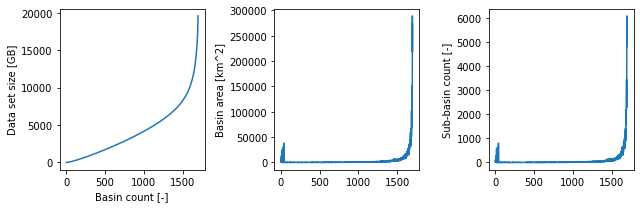

In [89]:
# Have a look at how this data is actually structured:
# Seems like area is a reasonable proxy for disk space needs, even if there are a few extremely odd outliers
fig,ax = plt.subplots(1,3,figsize=(9,3))
du_sort['cum_sum_size_gb'].plot(ax=ax[0]); ax[0].set_ylabel('Data set size [GB]'); ax[0].set_xlabel('Basin count [-]')
du_sort['Basin_area_km2'].plot(ax=ax[1]);  ax[1].set_ylabel('Basin area [km^2]'); ax[0].set_xlabel('Basin count [-]')
du_sort['sub_basins'].plot(ax=ax[2]);      ax[2].set_ylabel('Sub-basin count [-]'); ax[0].set_xlabel('Basin count [-]')
plt.tight_layout()

### Figure

In [90]:
# Find the consequences of different area thresholds on disk space and number of basins
area_th = np.linspace(0,4*10**5, num=100000)

In [91]:
basin_count = []
data_size = []
for th in area_th:
    mask = du_sort['Basin_area_km2'] <= th
    basin_count.append(mask.sum())
    data_size.append(du_sort[mask]['size_gb'].sum())

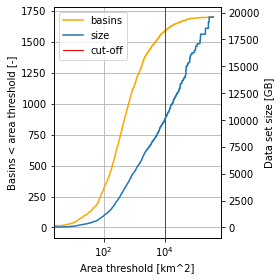

In [99]:
# Make a plot to summary theshold impact
fig, ax1 = plt.subplots(1,1,figsize=(4,4))
ax2 = ax1.twinx()
l1 = ax1.plot(area_th,basin_count, color='orange', label='basins')
l2 = ax2.plot(area_th,data_size, label='size')

ylim = ax1.get_ylim()
l3 = ax1.plot([10**4,10**4],[ylim[0],ylim[1]], 'r', label='cut-off', linewidth=1)
ax1.set_ylim(ylim[0],ylim[1])

ax1.set_ylabel('Basins < area threshold [-]')
ax2.set_ylabel('Data set size [GB]')
ax1.set_xlabel('Area threshold [km^2]')
ax1.set_xscale('log')

lns = l1+l2+l3
lbl = [l.get_label() for l in lns]
ax2.legend(lns, lbl)

ax1.grid()

plt.tight_layout()
plt.savefig(image_path/'data_set_size_by_area_threshold.png', dpi=300, bbox_inches='tight')

In [100]:
# Seems 10^4 is a neat place to cap things
area_threshold = 10**4 # [km^2]

In [106]:
# Check what we lose and gain
look_here = np.argmin(np.abs(area_th - area_threshold)) # Find the array index closest to 10^4
print(f'Removing {basin_count[-1]-basin_count[look_here]} basins, reducing disk space needs by {data_size[look_here]} GB')

Removing 113 basins, reducing disk space needs by 10039.010460832156 GB


### Update unusable with excluded basins

In [107]:
# Remove the old analysis - that one only included ERA5 and EM-Earth data and was decidedly premature
cs_unusable = cs_unusable[cs_unusable['Reason'] != 'Desire to limit disk space requirements']

In [108]:
# Add the excluded basins
mask = cs_meta['Basin_area_km2'] >= area_threshold

In [109]:
missing = 'n/a'
reason = 'Desire to limit disk space requirements'

In [110]:
# Make a dataframe that lists the basins we cannot use
tmp = pd.DataFrame({'Country': cs_meta[mask]['Country'],
                    'Station_id': cs_meta[mask]['Station_id'],
                    'Missing': missing,
                    'Reason': reason}).reset_index(drop=True)

In [112]:
cs_unusable = pd.concat([cs_unusable,tmp]).reset_index(drop=True)

In [118]:
cs_unusable.to_csv(cs_meta_path / cs_unusable_name, encoding='utf-8', index=False)

In [119]:
unique_ids = len(cs_unusable['Station_id'].unique())
print(f'Retaining {len(cs_meta)-unique_ids} out of {len(cs_meta)} basins.')
print('Note that for several basins we have identified more than one reason to remove them:')
cs_unusable['Reason'].value_counts()

Retaining 1426 out of 1698 basins.
Note that for several basins we have identified more than one reason to remove them:


No real-time discharge observations available        180
Desire to limit disk space requirements              113
No discharge values available (only water levels)     13
No Instantaneous Values of discharge available         4
Name: Reason, dtype: int64

### Disk space needs per basin category

In [120]:
# Create a temporary meta-data file with only the 1426 final basins
not_these = cs_unusable['Station_id'].unique() # we have some duplicates in here, this removes those
tmp = du[~du['Station_id'].isin(not_these)].copy()

In [121]:
tmp.reset_index(drop=True, inplace=True)

In [122]:
head_mask = tmp['is_headwater'] == 1
meso_mask = (tmp['is_headwater'] == 0) & (tmp['Basin_area_km2'] <= 10**3)
macr_mask = (tmp['is_headwater'] == 0) & (tmp['Basin_area_km2'] > 10**3) & (tmp['Basin_area_km2'] <= 10**4)

In [123]:
# Stats
head_numb = head_mask.sum()
head_size = tmp[head_mask]['size_gb'].sum()
head_area = tmp[head_mask]['Basin_area_km2'].mean()

meso_numb = meso_mask.sum()
meso_size = tmp[meso_mask]['size_gb'].sum()
meso_area = tmp[meso_mask]['Basin_area_km2'].mean()
meso_subs = tmp[meso_mask]['sub_basins'].mean()

macr_numb = macr_mask.sum()
macr_size = tmp[macr_mask]['size_gb'].sum()
macr_area = tmp[macr_mask]['Basin_area_km2'].mean()
macr_subs = tmp[macr_mask]['sub_basins'].mean()

In [124]:
print('Headwaters:')
print(f' Total number   = {head_numb}')
print(f' Total space    = {head_size:.2f} GB')
print(f' Mean area      = {head_area:.2f} km2 \n')
print('Meso-scale:')
print(f' Total number   = {meso_numb}')
print(f' Total space    = {meso_size:.2f} GB')
print(f' Mean area      = {meso_area:.2f} km2')
print(f' Mean subbasins = {meso_subs:.1f} \n')
print('Macro-scale:')
print(f' Total number   = {macr_numb}')
print(f' Total space    = {macr_size:.2f} GB')
print(f' Mean area      = {macr_area:.2f} km2')
print(f' Mean subbasins = {macr_subs:.1f} ')

Headwaters:
 Total number   = 304
 Total space    = 1100.53 GB
 Mean area      = 61.67 km2 

Meso-scale:
 Total number   = 727
 Total space    = 3570.66 GB
 Mean area      = 401.45 km2
 Mean subbasins = 8.7 

Macro-scale:
 Total number   = 395
 Total space    = 4403.02 GB
 Mean area      = 3029.03 km2
 Mean subbasins = 66.2 


### Update meta with subset category

In [130]:
cs_meta['subset_category'] = 'n/a'

In [132]:
head_mask = cs_meta['is_headwater'] == 1
meso_mask = (cs_meta['is_headwater'] == 0) & (cs_meta['Basin_area_km2'] <= 10**3)
macr_mask = (cs_meta['is_headwater'] == 0) & (cs_meta['Basin_area_km2'] > 10**3) & (cs_meta['Basin_area_km2'] <= 10**4)
drop_mask = (cs_meta['is_headwater'] == 0) & (cs_meta['Basin_area_km2'] > 10**4)

In [133]:
cs_meta.loc[head_mask, 'subset_category'] = 'headwater'
cs_meta.loc[meso_mask, 'subset_category'] = 'meso-scale'
cs_meta.loc[macr_mask, 'subset_category'] = 'macro-scale'
cs_meta.loc[drop_mask, 'subset_category'] = 'excluded'

In [134]:
cs_meta.to_csv(cs_meta_path / cs_meta_name, encoding='utf-8', index=False)